   INFO | len(ring)=7673 | ipykernel_15664.895300244
   INFO | Circumference error applied. | core.simulated_commissioning
   INFO | 0 BPMs registered. | core.simulated_commissioning
WARNING | BPMs not uniquely defined. | core.simulated_commissioning
WARNING | No horizontal CMs registered. Use register_magnets. | core.simulated_commissioning
WARNING | No vertical CMs registered. Use register_magnets. | core.simulated_commissioning


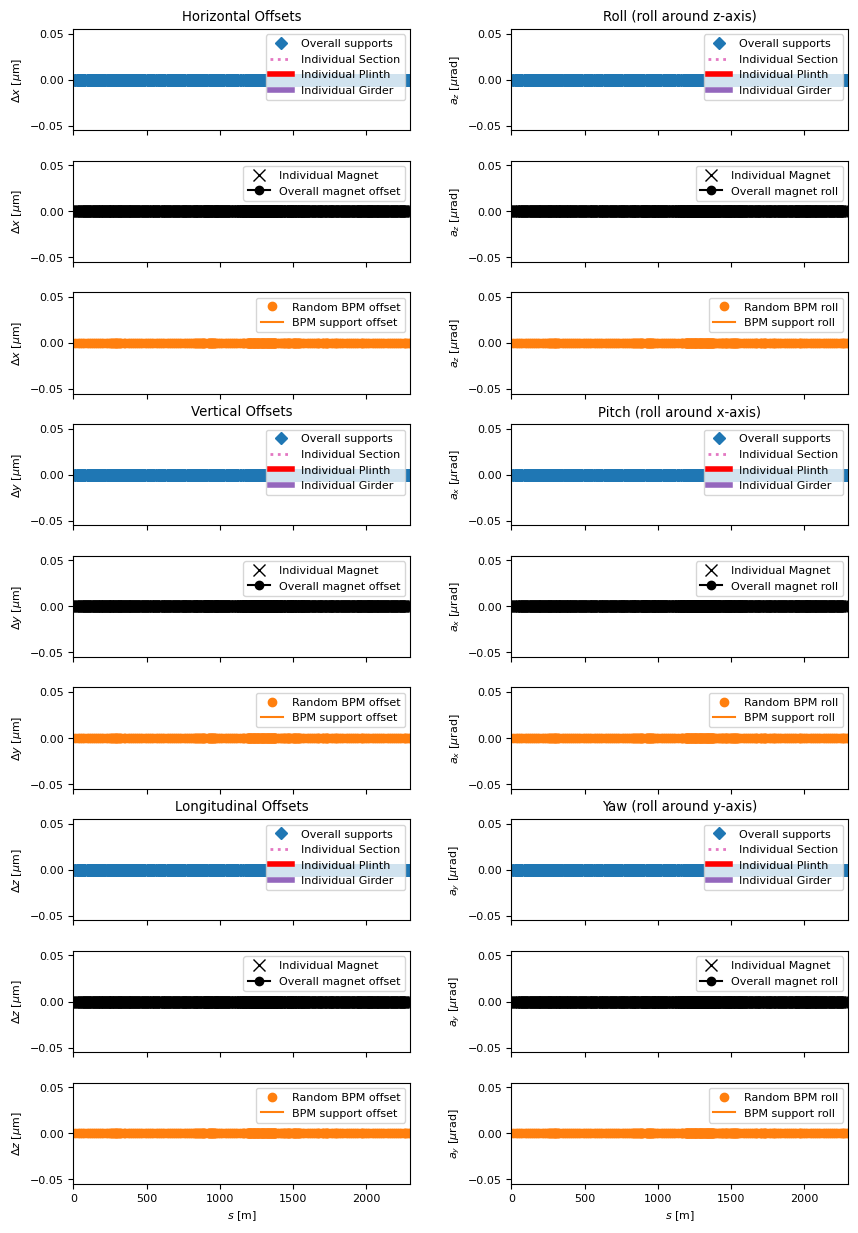

   INFO | Circumference error applied. | core.simulated_commissioning


c:\users\musa\desktop\pysc\pySC\plotting\plot_support.py:115: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [65]:
import at
import numpy as np
from at import Lattice
from pySC.utils.at_wrapper import atloco
from pySC.core.simulated_commissioning import SimulatedCommissioning
from pySC.correction.orbit_trajectory import SCfeedbackFirstTurn, SCfeedbackStitch, SCfeedbackRun, SCfeedbackBalance, \
    SCpseudoBBA
from pySC.core.beam import bpm_reading, beam_transmission
from pySC.core.constants import *
from pySC.correction.tune import tune_scan
from pySC.lattice_properties.response_model import SCgetModelRM, SCgetModelDispersion
from pySC.lattice_properties.response_measurement import *
from pySC.utils.sc_tools import SCgetOrds, SCgetPinv
from pySC.correction.loco_wrapper import (loco_model, loco_fit_parameters, apply_lattice_correction, loco_measurement,
                                          loco_bpm_structure, loco_cm_structure)
from pySC.plotting.plot_phase_space import plot_phase_space
from pySC.plotting.plot_support import plot_support
from pySC.plotting.plot_lattice import plot_lattice
from pySC.core.lattice_setting import set_magnet_setpoints, switch_cavity_and_radiation, set_cm_setpoints
from pySC.correction.rf import correct_rf_phase, correct_rf_frequency, phase_and_energy_error
from pySC.utils import logging_tools
#from pySC.correction.loco_modules import *
from pySC.correction.orbit_trajectory import SCfeedbackRun

from at_modules_loco import *

LOGGER = logging_tools.get_logger(__name__)


def create_at_lattice() -> Lattice:
    def _marker(name):
        return at.Marker(name, PassMethod='IdentityPass')
    new_ring = at.load_mat('p3_v24')
    new_ring.radiation_off()
    new_ring.energy = 6e9
    #new_ring.set_cavity(Voltage=1.66 ,Frequency=400786627.09839934)
    new_ring.enable_6d()
    at.set_cavity_phase(new_ring)
    at.set_rf_frequency(new_ring)
    new_ring.tapering(niter=3, quadrupole=True, sextupole=True)
    return new_ring


if __name__ == "__main__":
    ring = at.Lattice(create_at_lattice())
    nominal_tune = get_tune(ring, get_integer=True)
    nominal_crom = get_chrom(ring)
    LOGGER.info(f"{len(ring)=}")
    SC = SimulatedCommissioning(ring)

    ords = SCgetOrds(SC.RING, 'BPM')
    SC.register_bpms(ords,
                     Roll=0.0)

    sextOrds = SCgetOrds(SC.RING, 's')
    quadOrds = get_refpts(ring, at.elements.Quadrupole)

    ords = quadOrds
    SC.register_magnets(ords )

    ords = sextOrds
    SC.register_magnets(ords)



    SC.INJ.beamSize = np.diag(np.array([200E-6, 100E-6, 100E-6, 50E-6, 1E-3, 1E-4]) ** 2)
    SC.SIG.randomInjectionZ = np.array([1E-4, 1E-5, 1E-4, 1E-5, 1E-4, 1E-4])  # [m; rad; m; rad; rel.; m]
    SC.SIG.staticInjectionZ = np.array([1E-3, 1E-4, 1E-3, 1E-4, 1E-3, 1E-3])  # [m; rad; m; rad; rel.; m]
    SC.SIG.Circumference = 2E-4  # relative
    SC.INJ.beamLostAt = 0.6  # relative


    SC.apply_errors()
    SC.verify_structure()
    plot_support(SC)
    SC.apply_errors()

In [11]:
import numpy
def load_names(file_name):
    with open(file_name, 'r') as file:
        names = file.read().splitlines()
    return names

ORM_230426_3 =  np.loadtxt("ORM_230426_3.txt")
ORM_230426_1 =  np.loadtxt("ORM_230426_1.txt")
ORM_230426_2 =  np.loadtxt("ORM_230426_2.txt")
# measured ORM
Noise_BPMx_230426_3 =  np.loadtxt("Noise_BPMx_230426_3.txt")
Noise_BPMy_230426_3 =  np.loadtxt("Noise_BPMy_230426_3.txt")
Noise_BPMx_230426_1 =  np.loadtxt("Noise_BPMx_230426_1.txt")
Noise_BPMy_230426_1 =  np.loadtxt("Noise_BPMy_230426_1.txt")
Noise_BPMx_230426_2 =  np.loadtxt("Noise_BPMx_230426_2.txt")
Noise_BPMy_230426_2 =  np.loadtxt("Noise_BPMy_230426_2.txt")
BPM_names = load_names("BPM_names.txt")
HCM_names = load_names("HCM_names.txt")
VCM_names = load_names("VCM_names.txt")

In [34]:
cor_ind_x = [item for sublist in [SCgetOrds(SC.RING, i) for i in HCM_names] for item in sublist]
cor_ind_y = [item for sublist in [SCgetOrds(SC.RING, i) for i in VCM_names] for item in sublist]
used_bpm = [item for sublist in [SCgetOrds(SC.RING, i) for i in BPM_names] for item in sublist]
bpm_indices = get_refpts(ring, at.elements.Monitor)
Corords = [cor_ind_x, cor_ind_y]
CAVords = SCgetOrds(SC.RING, 'RF')
quads_indices = get_refpts(ring,at.elements.Quadrupole)
sorted_cor_ind_x = np.sort(cor_ind_x)
sorted_cor_ind_y = np.sort(cor_ind_y)
Corords = [sorted_cor_ind_x, sorted_cor_ind_y]

In [13]:
CMstep =  1.e-10 #correctors change [rad]
dk = 1.e-6 #quads change
RFstep = 1e3
[elemdata0, beamdata, elemdata] = at.get_optics(SC.IDEALRING, SC.ORD.BPM)
twiss = elemdata
[elemdata0, beamdata, elemdata] = at.get_optics(SC.RING, SC.ORD.BPM)
twiss_err = elemdata
emit0, bbb, eee = SC.RING.ohmi_envelope()
emittance_h = emit0['emitXY'][0]
emittance_v = emit0['emitXY'][1]
print('emittance_h', emittance_h, 'emittance_v',emittance_v)
print('emittance_h/ emittance_v', emittance_h/emittance_v)

emittance_h 1.2830652960242494e-09 emittance_v 0.0
emittance_h/ emittance_v inf


In [14]:
correctors_kick =1e-4

In [35]:
C_model = SCgetModelRM(SC, bpm_indices, Corords, trackMode='ORB', useIdealRing=True, dkick= correctors_kick)

   INFO | Calculating model response matrix | lattice_properties.response_model


In [16]:
shape(C_model)

(492, 96)

In [17]:
Corords

[[6739,
  6733,
  6667,
  6661,
  6653,
  6647,
  6581,
  6575,
  6345,
  6323,
  6275,
  6245,
  6223,
  6175,
  6145,
  6123,
  6089,
  6059,
  6037,
  5989,
  5959,
  5937,
  5903,
  5873,
  5851,
  5803,
  5773,
  5751,
  5717,
  5687,
  5665,
  5617,
  5587,
  5288,
  5280,
  5214,
  5208,
  5200,
  5194,
  5128,
  5122],
 [6719,
  6683,
  6663,
  6651,
  6631,
  6595,
  6571,
  6369,
  6355,
  6331,
  6317,
  6283,
  6267,
  6255,
  6231,
  6217,
  6183,
  6167,
  6155,
  6131,
  6117,
  6097,
  6081,
  6069,
  6045,
  6031,
  5997,
  5981,
  5969,
  5945,
  5931,
  5911,
  5895,
  5883,
  5859,
  5845,
  5811,
  5795,
  5783,
  5759,
  5745,
  5725,
  5709,
  5697,
  5673,
  5659,
  5625,
  5609,
  5597,
  5266,
  5230,
  5210,
  5198,
  5178,
  5142]]

In [19]:
def ORM_x1(dkick, ring, used_correctors_ind, used_bpm):
    cxx_p = []
    cxy_p = []
    cxx_m = []
    cxy_m = []

    _, _, elemdata = at.get_optics(ring, used_bpm)
    closed_orbitx0 = elemdata.closed_orbit[:, 0]
    closed_orbity0 = elemdata.closed_orbit[:, 2]
    for cor_index in used_correctors_ind:
        a = ring[cor_index].KickAngle[0]
        ring[cor_index].KickAngle[0] = dkick/2 + a
        _, _, elemdata = at.get_optics(ring, used_bpm)
        closed_orbitx = elemdata.closed_orbit[:, 0] - closed_orbitx0
        closed_orbity = elemdata.closed_orbit[:, 2] - closed_orbity0
        cxx_p.append(closed_orbitx)
        cxy_p.append(closed_orbity)

        ring[cor_index].KickAngle[0] = -dkick / 2 + a

        _, _, elemdata = at.get_optics(ring, used_bpm)
        closed_orbitx = elemdata.closed_orbit[:, 0] - closed_orbitx0
        closed_orbity = elemdata.closed_orbit[:, 2] - closed_orbity0
        cxx_m.append(closed_orbitx)
        cxy_m.append(closed_orbity)


        ring[cor_index].KickAngle[0] = a
    Cxx = (np.squeeze(cxx_p)-np.squeeze(cxx_m))/dkick
    Cxy = (np.squeeze(cxy_p)-np.squeeze(cxy_m))/dkick

    return Cxx, Cxy


def ORM_y1(dkick, ring, used_correctors_ind, used_bpm):
    cyy_p = []
    cyx_p = []
    cyy_m = []
    cyx_m = []

    _, _, elemdata = at.get_optics(ring, used_bpm)
    closed_orbitx0 = elemdata.closed_orbit[:, 0]
    closed_orbity0 = elemdata.closed_orbit[:, 2]
    for cor_index in used_correctors_ind:

        a = ring[cor_index].KickAngle[1]
        ring[cor_index].KickAngle[1] = dkick/2 + a
        _, _, elemdata = at.get_optics(ring, used_bpm)
        closed_orbitx = elemdata.closed_orbit[:, 0] - closed_orbitx0
        closed_orbity = elemdata.closed_orbit[:, 2] - closed_orbity0
        cyy_p.append(closed_orbity)
        cyx_p.append(closed_orbitx)

        ring[cor_index].KickAngle[1] = -dkick / 2 + a

        _, _, elemdata = at.get_optics(ring, used_bpm)
        closed_orbitx = elemdata.closed_orbit[:, 0] - closed_orbitx0
        closed_orbity = elemdata.closed_orbit[:, 2] - closed_orbity0
        cyy_m.append(closed_orbity)
        cyx_m.append(closed_orbitx)


        ring[cor_index].KickAngle[1] = a
    Cyy = (np.squeeze(cyy_p)-np.squeeze(cyy_m))/dkick
    Cyx = (np.squeeze(cyx_p)-np.squeeze(cyx_m))/dkick

    return Cyy, Cyx

In [36]:
Cx0, Cxy0= ORM_x1(correctors_kick, ring,Corords[0], bpm_indices)
Cy0, Cyx0= ORM_y1(correctors_kick, ring, Corords[1], bpm_indices)

In [37]:
Cx0 = transpose(Cx0)
Cy0 = transpose(Cy0)
Cxy0 = transpose(Cxy0)
Cyx0 = transpose(Cyx0)

In [38]:
shape(Cx0)

(246, 41)

In [39]:

X = np.zeros((Cx0.shape[0]+Cy0.shape[0], Cx0.shape[1]+Cy0.shape[1]))
X[:Cx0.shape[0], :Cx0.shape[1]] = Cx0
X[:Cx0.shape[0], Cx0.shape[1]:] = Cyx0
X[Cx0.shape[0]:, :Cx0.shape[1]] = Cxy0
X[Cx0.shape[0]:, Cx0.shape[1]:] = Cy0

In [40]:
shape(X)

(492, 96)

In [41]:
shape(C_model)

(492, 96)

Text(0.5, 1.0, 'Model2')

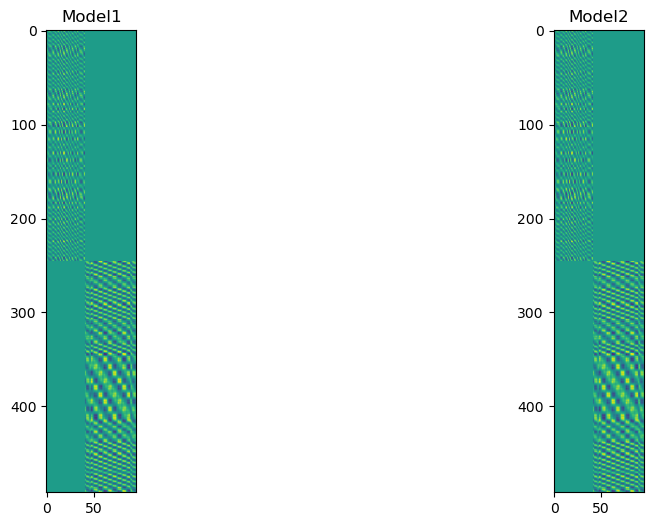

In [42]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('Model1')
plt.subplot(1, 2, 2)
plt.imshow(C_model)
plt.title('Model2')

In [69]:
X

array([[-1.28391230e+01,  7.89129307e-01,  6.17367377e+00, ...,
        -3.50830459e-15,  6.80273336e-16,  2.09931822e-15],
       [-1.25624034e+01, -3.85442097e+00,  7.22023406e+00, ...,
        -3.77988453e-16,  1.91111809e-15, -1.21919805e-15],
       [ 2.74579033e+00, -2.42645861e+00, -7.77192265e-01, ...,
         2.58795035e-15,  9.46426970e-16, -2.04277215e-15],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.30731198e+01, -8.84337053e+00,  6.69100448e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16675397e+01, -1.08891677e+01, -4.45403738e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.01101515e+00, -5.18186064e+00, -9.40100565e+00]])

In [72]:
Cx0 = X[:Cx0.shape[0], :Cx0.shape[1]]
Cyx0 = X[:Cx0.shape[0], Cx0.shape[1]:]
Cxy0 = X[Cx0.shape[0]:, :Cx0.shape[1]]
Cy0 = X[Cx0.shape[0]:, Cx0.shape[1]:]

Cx1 = C_model[:Cx0.shape[0], :Cx0.shape[1]]
Cyx1 = C_model[:Cx0.shape[0], Cx0.shape[1]:]
Cxy1 = C_model[Cx0.shape[0]:, :Cx0.shape[1]]
Cy1 = C_model[Cx0.shape[0]:, Cx0.shape[1]:]

In [79]:
Cyx0

array([[ 6.53274161e-16,  2.91829320e-16, -2.79256175e-17, ...,
        -3.50830459e-15,  6.80273336e-16,  2.09931822e-15],
       [-3.72800376e-15, -1.67765463e-15,  1.28272552e-15, ...,
        -3.77988453e-16,  1.91111809e-15, -1.21919805e-15],
       [-1.57481954e-15, -1.98324824e-15,  4.72948787e-16, ...,
         2.58795035e-15,  9.46426970e-16, -2.04277215e-15],
       ...,
       [ 5.22884026e-15,  2.84656010e-15, -2.78673840e-15, ...,
        -9.04207671e-16, -2.12419981e-15,  3.40242547e-15],
       [ 3.37648509e-15,  4.07608136e-15, -2.91273455e-15, ...,
        -4.19731295e-15, -7.90652317e-16,  4.09699249e-15],
       [-2.66815378e-16,  2.13730235e-15, -1.08698150e-15, ...,
        -3.86630836e-15,  8.26386519e-16,  1.76818128e-15]])

In [90]:
Cx*10

array([[-11.484601  ,   0.83844192,   5.2852764 , ...,   6.5507686 ,
         -3.8469209 , -11.029883  ],
       [-11.552822  ,  -3.0292675 ,   6.3628299 , ...,   5.3971599 ,
         -1.4161026 , -12.361769  ],
       [  2.1965675 ,  -2.1464564 ,  -0.50444758, ...,  -1.8916197 ,
          1.9839257 ,   1.4675985 ],
       ...,
       [ 15.09469   ,   1.4255886 ,  -7.6589702 , ...,  -7.8408132 ,
          3.4382904 ,  15.303697  ],
       [  6.9515057 ,   4.5026208 ,  -4.5678793 , ...,  -2.4304699 ,
         -0.85404005,   8.3088462 ],
       [ -2.4563537 ,   3.8155838 ,   0.14048785, ...,   2.5171154 ,
         -3.1306787 ,  -1.1705559 ]])

In [81]:
Cx = np.array(ORM_230426_1)[:len(BPM_names), :len(HCM_names)]
Cyx = np.array(ORM_230426_1)[:len(BPM_names), len(HCM_names):]
Cxy = np.array(ORM_230426_1)[len(BPM_names):, :len(HCM_names)]
Cy = np.array(ORM_230426_1)[len(BPM_names):, len(HCM_names):]

Y = np.zeros((Cx.shape[0]+Cy.shape[0], Cx.shape[1]+Cy.shape[1]))
Y[:Cx.shape[0], :Cx.shape[1]] = Cx
Y[:Cx.shape[0], Cx.shape[1]:] = Cyx
Y[Cx.shape[0]:, :Cx.shape[1]] = Cxy
Y[Cx.shape[0]:, Cx.shape[1]:] = Cy

In [49]:
shape(Y)

(492, 96)

Text(0.5, 1.0, 'Model2')

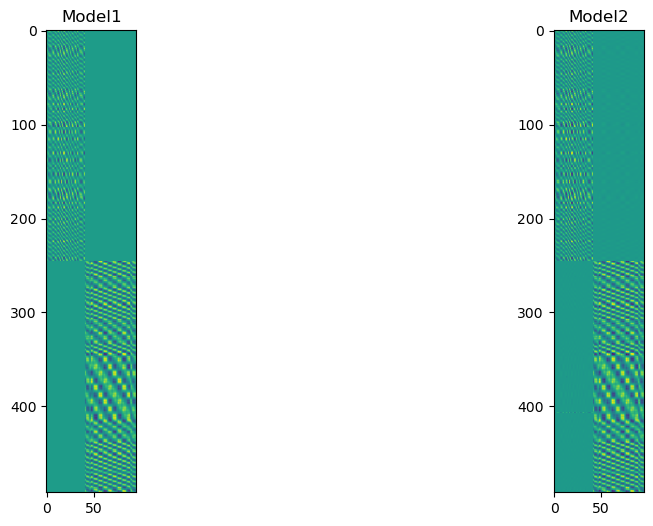

In [85]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(C_model)
plt.title('Model1')
plt.subplot(1, 2, 2)
plt.imshow(Y)
plt.title('Model2')

In [51]:
C_model

array([[-1.28328969e+01,  7.87708226e-01,  6.17849288e+00, ...,
        -7.30224656e-03, -2.16640757e-03, -1.44085309e-03],
       [-1.25615139e+01, -3.85716064e+00,  7.21879471e+00, ...,
        -4.04327562e-03,  7.21470725e-04, -2.67642011e-03],
       [ 2.74033324e+00, -2.42647817e+00, -7.81915058e-01, ...,
         3.59383614e-03,  1.93753870e-03, -1.34676150e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.30732209e+01, -8.84340599e+00,  6.69101884e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16675656e+01, -1.08892072e+01, -4.45407532e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.01097301e+00, -5.18187737e+00, -9.40105586e+00]])

In [53]:
Y*10

array([[-11.484601  ,   0.83844192,   5.2852764 , ...,   0.76280976,
          0.44566063,  -0.32004749],
       [-11.552822  ,  -3.0292675 ,   6.3628299 , ...,   0.02721821,
         -0.05476784,  -0.07588772],
       [  2.1965675 ,  -2.1464564 ,  -0.50444758, ...,  -0.28519939,
         -0.17416707,   0.08424086],
       ...,
       [  0.82836386,   0.11800063,  -0.45779708, ...,  -8.4048876 ,
         -5.6775765 ,   4.0144316 ],
       [  0.1466597 ,   0.0143426 ,  -0.14368209, ...,  -9.2709765 ,
         -9.2046649 ,  -5.6655593 ],
       [ -0.21994511,  -0.08028299,   0.08386859, ...,  -1.621967  ,
         -4.1344833 ,  -9.6687188 ]])

In [95]:
dCx = np.load('dCx_p3_hv.npy') # Jacobian calculated using HCM / VCM
dCy = np.load('dCy_p3_hv.npy')
dCxy =  np.load('dCxy_p3_hv.npy')
dCyx = np.load('dCyx_p3_hv.npy')

dCx =  np.transpose(dCx, (0, 2, 1))
dCy =  np.transpose(dCy, (0, 2, 1))
dCxy =  np.transpose(dCxy, (0, 2, 1))
dCyx =  np.transpose(dCyx, (0, 2, 1))

J = np.zeros((len(dCx), Cx0.shape[0] + Cy0.shape[0], Cx0.shape[1] + Cy0.shape[1]))

J[:, :dCx.shape[1], :dCx.shape[2]] = dCx
J[:, :dCx.shape[1], dCx.shape[2]:] = dCyx
J[:, dCx.shape[1]:, :dCx.shape[2]] = dCxy
J[:, dCx.shape[1]:, dCx.shape[2]:] = dCy

In [100]:
bpm_noise = Noise_BPMx_230426_1/1000
min_value = np.min(abs(bpm_noise))
bpm_noise /= min_value
diagonal_values = 1 / np.square(bpm_noise)
W = np.diag(diagonal_values)
print(W)

[[0.00356713 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00852905 0.         ... 0.         0.         0.        ]
 [0.         0.         0.02389294 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.003142   0.         0.        ]
 [0.         0.         0.         ... 0.         0.11531502 0.        ]
 [0.         0.         0.         ... 0.         0.         0.01137613]]


In [113]:
def loco_correction(objective_function, initial_guess0, orbit_response_matrix_model, orbit_response_matrix_measured, J, Jt, lengths, including_fit_parameters, method='lm', verbose=2, max_iterations=1000, eps=1e-6):
    from scipy.optimize import least_squares
    from sklearn.metrics import r2_score, mean_squared_error
    if method == 'lm':
        result = least_squares(objective_function, initial_guess0, method=method, verbose=verbose)
        params_to_check = calculate_parameters(result.x, orbit_response_matrix_model, orbit_response_matrix_measured, J, lengths,including_fit_parameters)
        return result, params_to_check
    else:
        if method == 'ng':
            Iter = 0
            while True:
                Iter += 1

                if max_iterations is not None and Iter > max_iterations:
                    break

                model = orbit_response_matrix_model
                if 'quads' in including_fit_parameters:
                    len_quads = lengths[0]
                    delta_g = initial_guess0[:len_quads]
                    B = np.sum([J[k] * delta_g[k] for k in range(len(delta_g))], axis=0)
                    model += B

                if 'cor' in including_fit_parameters:
                    len_corr = lengths[1]
                    delta_x = initial_guess0[len_quads:len_quads + len_corr]
                    Co = orbit_response_matrix_model * delta_x
                    model += Co

                if 'bpm' in including_fit_parameters:
                    len_bpm = lengths[2]
                    delta_y = initial_guess0[len_quads + len_corr:]
                    G = orbit_response_matrix_model * delta_y[:, np.newaxis]
                    model += G


                r = orbit_response_matrix_measured - model

                t2 = np.zeros([len(initial_guess0), 1])
                for i in range(len(initial_guess0)):
                    t2[i] = np.sum(np.dot(J[i], r.T))

                t3 = (np.dot(Jt, t2)).reshape(-1)
                initial_guess1 = initial_guess0 + t3 #+
                t4 = abs(initial_guess1 - initial_guess0)

                if max(t4) <= eps:
                    break
                initial_guess0 = initial_guess1

            # params_to_check_ = calculate_parameters(initial_guess0, orbit_response_matrix_model, orbit_response_matrix_measured, J, lengths,
            #                     including_fit_parameters,W)

            delta_g = initial_guess0[:len_quads]
            #delta_x = initial_guess0[len_quads:len_quads + len_corr]
            #delta_y = initial_guess0[len_quads + len_corr:]

            D = orbit_response_matrix_measured - orbit_response_matrix_model
            B = np.sum([J[k] * delta_g[k] for k in range(len(delta_g))], axis=0)
            #Co = orbit_response_matrix_model * delta_x
            #G = orbit_response_matrix_model * delta_y[:, np.newaxis]
            model = orbit_response_matrix_model + B
            residuals = orbit_response_matrix_measured - model

            r_squared = r2_score(orbit_response_matrix_measured, model)
            rms = sqrt(mean_squared_error(orbit_response_matrix_measured, model))

            params_to_check_ = {
                #'residulas': residuals,
           'r_squared': r_squared,
            'rmse': rms,
            }


        return initial_guess0, params_to_check_


def objective(delta_params, orbit_response_matrix_model, orbit_response_matrix_measured, J, lengths, including_fit_parameters):

    D = orbit_response_matrix_measured - orbit_response_matrix_model
    residuals = D
    if 'quads' in including_fit_parameters:
        len_quads = lengths[0]
        delta_g = delta_params[:len_quads]
        B = np.sum([J[k] * delta_g[k] for k in range(len(delta_g))], axis=0)
        residuals -= B

    if 'cor' in including_fit_parameters:
        len_corr = lengths[1]
        delta_x = delta_params[len_quads:len_quads + len_corr]
        Co = orbit_response_matrix_model * delta_x
        residuals -= Co

    if 'bpm' in including_fit_parameters:
        len_bpm = lengths[2]
        delta_y = delta_params[len_quads + len_corr:]
        G = orbit_response_matrix_model * delta_y[:, np.newaxis]
        residuals -= G

    residuals = residuals

    return residuals.ravel()



def calculate_parameters(parameters, orbit_response_matrix_model, orbit_response_matrix_measured, J, lengths, including_fit_parameters):
    model = orbit_response_matrix_model
    len_quads = lengths[0]
    #len_corr = lengths[1]
    #len_bpm = lengths[2]

    if 'quads' in including_fit_parameters:
        delta_g = parameters[:len_quads]
        B = np.sum([J[k] * delta_g[k] for k in range(len(delta_g))], axis=0)
        model += B

    if 'cor' in including_fit_parameters:
        len_corr = lengths[1]
        delta_x = parameters[len_quads:len_quads + len_corr]
        Co = orbit_response_matrix_model * delta_x
        model += Co

    if 'bpm' in including_fit_parameters:
        len_bpm = lengths[2]
        delta_y = parameters[len_quads + len_corr:]
        G = orbit_response_matrix_model * delta_y[:, np.newaxis]
        model += G



    residuals = orbit_response_matrix_measured- model
    # Calculate R-squared
    r_squared = r2_score(orbit_response_matrix_measured, model)

    # Calculate RMSE
    rms = sqrt(mean_squared_error(orbit_response_matrix_measured,model))

    params_to_check_ = {

        'r_squared': r_squared,
        'rmse': rms,
    }

    return params_to_check_

In [114]:
quadsOrds = quads_indices
initial_guess = np.zeros(len((quadsOrds)) + len(np.concatenate(Corords)) +  len(bpm_indices) *2)
initial_guess[0:len((quadsOrds))] = 0
initial_guess[len((quadsOrds)):len((quadsOrds)) + len(np.concatenate(Corords))] = 1
initial_guess[len((quadsOrds)) + len(np.concatenate(Corords)):] = 1
lengths = [len((quadsOrds)),len(np.concatenate(Corords)),  len(bpm_indices) *2]
including_fit_parameters = ['quads', 'cor', 'bpm']

In [115]:
start_time = time.time()
fit_parameters, params_to_check  = loco_correction(lambda delta_params: objective(delta_params, X, Y, J, lengths, including_fit_parameters),initial_guess,X, Y, J,0, lengths,including_fit_parameters
                         , verbose=2, max_iterations= 100, eps=1e-6, method='lm')
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time taken by lm: {elapsed_time} seconds")

`xtol` termination condition is satisfied.
Function evaluations 2035, initial cost 7.6789e+06, final cost 7.0912e+01, first-order optimality 2.73e+02.


NameError: name 'r2_score' is not defined

In [ ]:
def setCorrection(ring, r ,quadInd):
    for i in range(len(quadInd)):
        qInd = quadInd[i]
        ring[qInd].K -= -r[i]

setCorrection(ring, r , quads_indices)
_, _, twiss_cor = at.get_optics(ring, bpm_indices)

In [ ]:
Beta_x = twiss.beta[:, 0]
Beta_y = twiss.beta[:, 1]
print('Beta beating after corrections')
bx_rms_cor, by_rms_cor = getBetaBeat(ring, twiss, bpm_indices, makeplot = True)
_, _, twiss = at.get_optics(ring, bpm_indices)
s_pos = twiss.s_pos
Beta_x = twiss.beta[:, 0]
Beta_y = twiss.beta[:, 1]

plt.rc('font', size=13)
fig, ax = plt.subplots()
ax.plot(s_pos, Beta_x)
ax.set_xlabel("s_pos [m]", fontsize=14)
ax.set_ylabel(r'$\beta_x%$', fontsize=14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.grid(True, which='both', linestyle=':', color='gray')
plt.title('Horizontal beta')
plt.show()
fig, ax = plt.subplots()
ax.plot(s_pos, Beta_y)
ax.set_xlabel("s_pos [m]", fontsize=14)
ax.set_ylabel(r'$\beta_y%$', fontsize=14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.grid(True, which='both', linestyle=':', color='gray')
plt.title('Vertical beta')
plt.show()